# NLP - Recurrent Neural Network

In this notebook, we will work on Toxic Comment dataset
---

We will cover the following techniques:

* Turn *raw text* into something neural networks can process. 
* How to **tokenize** text. 
* Use **Embedding layer**.
* Use **pre-trained word Embedding**.
* Use RNN : SimpleRNN, LSTM, Bidirectional LSTM..



# Download the data

* Head to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge to download the data.

* Download "train.csv", "test.csv", "test_labels.csv" and put them in a folder named data

* Files Description: 
    * train.csv - the training set, contains comments with their binary labels
    * test.csv - the test set, you must predict the toxicity probabilities for these comments. 
    * test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

* Data Description:
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

    * toxic
    * severe_toxic
    * obscene
    * threat
    * insult
    * identity_hate


* Objective : Create a model which predicts a probability of each type of toxicity for each comment.
-----

First, create a list of texts and a list of labels from the data folder

In [2]:
# Import Modules
import pandas as pd
import os

In [3]:
data_dir = os.path.join(os.getcwd(), "data")
train = pd.read_csv(os.path.join(data_dir, "train.csv"))
texts = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels = train[possible_labels].values

In [4]:
texts.shape

(159571,)

In [5]:
labels.shape

(159571, 6)

# Parameters

In [8]:
max_length = 100
max_words = 20000
embedding_dim = 100

# Tokenize the data

In [7]:
# Import Modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

* Create the word index dictionary and print the number of tokens 

In [9]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 210337 unique tokens.


* Convert the texts to sequences of integers of the same length

In [10]:
# From texts to sequences of integers 
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen= max_length)
labels = np.asarray(labels)

* Shuffle data

In [11]:
# Shuffle Data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


* Split data into train and test

In [12]:
# Split 
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]

# Using Embedding Layer

* Create a model with Sequential() and train the embedding layer with the rest of the model

In [13]:
# Create a model with Embedding Layer
from tensorflow.keras import models, layers

In [14]:
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(len(possible_labels), activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 60006     
Total params: 2,060,006
Trainable params: 2,060,006
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer="rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [16]:
history = model.fit(train_data, train_labels, epochs = 5, batch_size=128, validation_split=.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 23s 222us/sample - loss: 0.0873 - accuracy: 0.9724 - val_loss: 0.0719 - val_accuracy: 0.9759
Epoch 2/5
102124/102124 [==============================] - 21s 207us/sample - loss: 0.0665 - accuracy: 0.9782 - val_loss: 0.0686 - val_accuracy: 0.9774
Epoch 3/5
102124/102124 [==============================] - 21s 202us/sample - loss: 0.0617 - accuracy: 0.9796 - val_loss: 0.0689 - val_accuracy: 0.9770
Epoch 4/5
102124/102124 [==============================] - 21s 202us/sample - loss: 0.0569 - accuracy: 0.9809 - val_loss: 0.0700 - val_accuracy: 0.9772
Epoch 5/5
102124/102124 [==============================] - 21s 204us/sample - loss: 0.0517 - accuracy: 0.9825 - val_loss: 0.0721 - val_accuracy: 0.9769


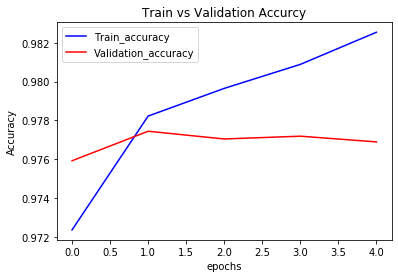

In [17]:
plt.plot(history.history["accuracy"], "b", label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], "r", label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

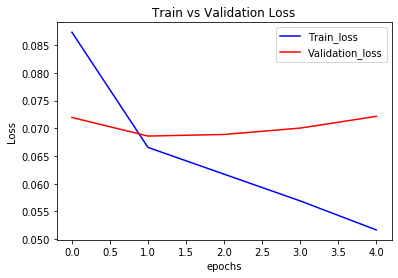

In [18]:
plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

In [19]:
model.evaluate(test_data, test_labels)

31915/31915 [==============================] - 5s 167us/sample - loss: 0.0730 - accuracy: 0.9779


[0.07302240018100924, 0.9779256]

# Using Pre-trained Word Embedding

* Now, Instead of learning word embeddings jointly with the problem, we want to load pre-trained word Embeddings. 

* The idea of a dense, lowdimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s,1 but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the **Word2vec algorithm**, developed by Tomas Mikolov at Google in 2013. 

* Another popular one is called Global Vectors for Word Representation , which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data.

* In this practical implementation, we will use **Glove Word Embeddings**. 

* Go to https://nlp.stanford.edu/projects/glove, and download the precomputed embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it.

### Embedding_index : dictionary { word : vector}

In [21]:
dir_glove = os.path.join(os.getcwd(),'glove.6B')

embedding_index = {}
    
f = open(os.path.join(dir_glove, "glove.6B.100d.txt"), encoding = "utf8")
for line in f:
    values = line.split()
    word = values[0]
    embedding_index[word] = np.asarray(values[1:], dtype = "float32")
f.close()

### Embedding_matrix of shape (max_words, embedding_dimension)

In [22]:
embedding_matrix = np.zeros((max_words,embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### load pre-trained word embeddings into an Embedding layer

In [23]:
num_words = min(max_words, len(word_index) + 1)

embedding_layer = layers.Embedding(
  num_words,
  embedding_dim,
  weights=[embedding_matrix],
  input_length=max_length,
  trainable=False
)

### Create a Model with a pre-trained Embedding layer

In [24]:
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.Flatten())
model.add(layers.Dense(len(possible_labels), activation = "sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 60006     
Total params: 2,060,006
Trainable params: 60,006
Non-trainable params: 2,000,000
_________________________________________________________________


In [25]:
model.compile(optimizer="rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [26]:
history = model.fit(train_data, train_labels, epochs = 5, batch_size=128, validation_split=.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 10s 100us/sample - loss: 0.1009 - accuracy: 0.9693 - val_loss: 0.0910 - val_accuracy: 0.9708
Epoch 2/5
102124/102124 [==============================] - 10s 97us/sample - loss: 0.0796 - accuracy: 0.9742 - val_loss: 0.0884 - val_accuracy: 0.9715
Epoch 3/5
102124/102124 [==============================] - 10s 96us/sample - loss: 0.0723 - accuracy: 0.9760 - val_loss: 0.0904 - val_accuracy: 0.9721
Epoch 4/5
102124/102124 [==============================] - 11s 105us/sample - loss: 0.0675 - accuracy: 0.9771 - val_loss: 0.0916 - val_accuracy: 0.9726
Epoch 5/5
102124/102124 [==============================] - 12s 121us/sample - loss: 0.0640 - accuracy: 0.9783 - val_loss: 0.0932 - val_accuracy: 0.9724


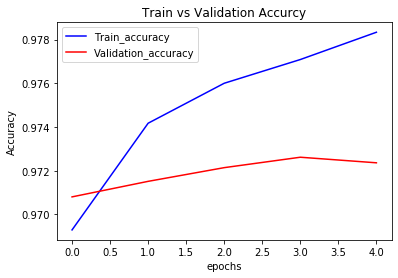

In [27]:
plt.plot(history.history["accuracy"], "b", label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], "r", label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

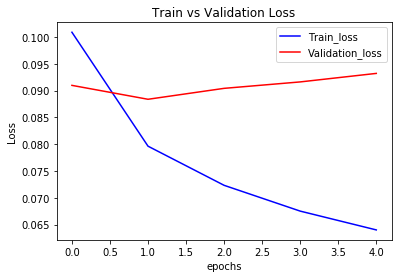

In [28]:
plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

In [29]:
model.evaluate(test_data, test_labels)

31915/31915 [==============================] - 6s 181us/sample - loss: 0.0924 - accuracy: 0.9739


[0.09241166022080492, 0.97393084]

# Using Recurrent Neural Network 

### Simple RNN with numpy  

In [30]:
# Basic Recurrent Layer
T = 100
D = 10
V = 15


inputs = np.random.random((T,D))
W = np.random.random((V, D))
U = np.random.random((V, V))
b = np.random.random((V,))
    
s_t = np.zeros((V,))
outputs = []
for input in inputs:
    output = np.tanh(np.dot(W, input) + np.dot(U, s_t) + b) 
    outputs.append(output)
    s_t = output

outputs = np.asarray(outputs)

In [31]:
inputs.shape

(100, 10)

In [32]:
output.shape

(15,)

### SimpleRNN on dataset

In [33]:
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.SimpleRNN(embedding_dim))
model.add(layers.Dense(len(possible_labels), activation = "sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 2,020,706
Trainable params: 20,706
Non-trainable params: 2,000,000
_________________________________________________________________


In [34]:
model.compile(optimizer="rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [35]:
history = model.fit(train_data, train_labels, epochs = 5, batch_size=128, validation_split=.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 61s 601us/sample - loss: 0.0981 - accuracy: 0.9678 - val_loss: 0.0805 - val_accuracy: 0.9731
Epoch 2/5
102124/102124 [==============================] - 55s 537us/sample - loss: 0.0809 - accuracy: 0.9722 - val_loss: 0.0901 - val_accuracy: 0.9703
Epoch 3/5
102124/102124 [==============================] - 71s 695us/sample - loss: 0.0766 - accuracy: 0.9739 - val_loss: 0.0728 - val_accuracy: 0.9762
Epoch 4/5
102124/102124 [==============================] - 51s 504us/sample - loss: 0.0730 - accuracy: 0.9752 - val_loss: 0.0793 - val_accuracy: 0.9755
Epoch 5/5
102124/102124 [==============================] - 47s 462us/sample - loss: 0.0741 - accuracy: 0.9745 - val_loss: 0.0725 - val_accuracy: 0.9757


In [36]:
# Evaluate the model 
model.evaluate(test_data, test_labels)

31915/31915 [==============================] - 23s 707us/sample - loss: 0.0688 - accuracy: 0.9768


[0.06875329990848635, 0.9767718]

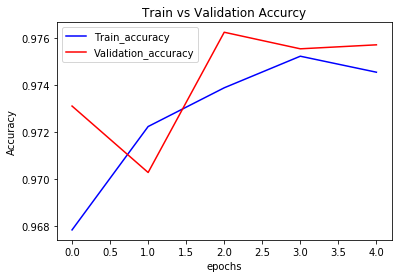

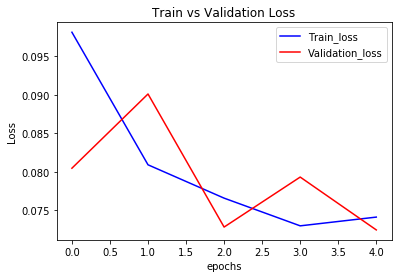

In [37]:
# Plots 
plt.plot(history.history["accuracy"], "b", label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], "r", label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

### LSTM with Global MaxPool 

In [38]:
# Create the Model
output_dim = 15
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(output_dim, return_sequences = True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(len(possible_labels), activation = "sigmoid"))
model.summary()

model.compile(optimizer="rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(train_data, train_labels, epochs = 5, batch_size=128, validation_split=.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 15)           6960      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 96        
Total params: 2,007,056
Trainable params: 7,056
Non-trainable params: 2,000,000
_________________________________________________________________
Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 64s 630us/sample - loss: 0.1654 - accuracy: 0.9450 - val_loss: 0.0810 - val_accuracy: 0.9714
Epoch 2/5
102124/102124 [==========

In [39]:
# Evaluate the model 
model.evaluate(test_data, test_labels)

31915/31915 [==============================] - 32s 998us/sample - loss: 0.0548 - accuracy: 0.9809


[0.05482562551271686, 0.9808862]

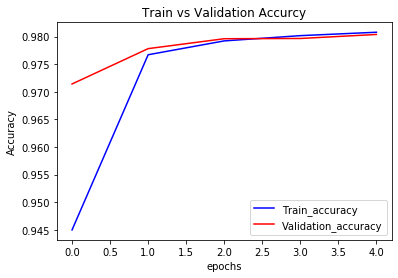

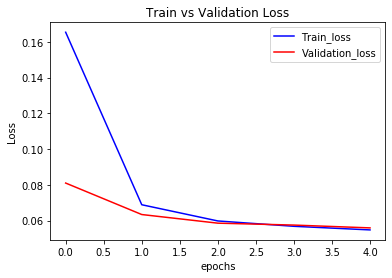

In [40]:
# Plots 
plt.plot(history.history["accuracy"], "b", label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], "r", label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

### Bidirectional LSTM with GlobalMaxPool

In [41]:
output_dim = 15
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(output_dim, return_sequences = True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(len(possible_labels), activation = "sigmoid"))
model.summary()

model.compile(optimizer="rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(train_data, train_labels, epochs = 5, batch_size=128, validation_split=.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 186       
Total params: 2,014,106
Trainable params: 14,106
Non-trainable params: 2,000,000
_________________________________________________________________
Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 92s 904us/sample - loss: 0.1037 - accuracy: 0.9696 - val_loss: 0.0668 - val_accuracy: 0.9765
Epoch 2/5
102124/102124 [=========

In [42]:
# Evaluate the model 
model.evaluate(test_data, test_labels)

31915/31915 [==============================] - 41s 1ms/sample - loss: 0.0530 - accuracy: 0.9809


[0.053005972675968634, 0.9809181]

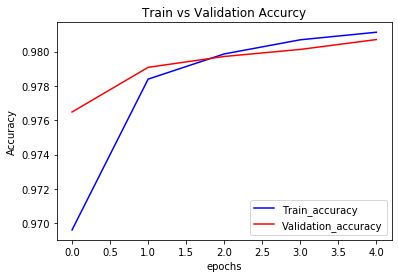

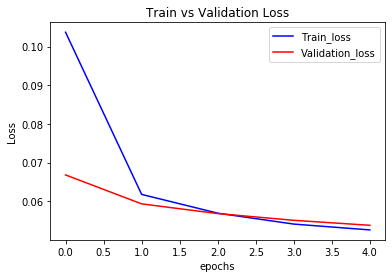

In [43]:
# Plots 
plt.plot(history.history["accuracy"], "b", label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], "r", label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()